In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download ashishjangra27/face-mask-12k-images-dataset

 94% 309M/330M [00:02<00:00, 98.8MB/s]
100% 330M/330M [00:03<00:00, 114MB/s] 


In [ ]:
!unzip face-mask-12k-images-dataset

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

In [ ]:
train_dir = "/content/Face Mask Dataset/Train"
test_dir = "/content/Face Mask Dataset/Test"
val_dir = "/content/Face Mask Dataset/Validation"

In [ ]:
import numpy as np  # linear algebra
import cv2 # opencv
import matplotlib.pyplot as plt # image plotting
# keras
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [ ]:
# Train data
datagenerator = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2
)
train_generator = datagenerator.flow_from_directory(
    directory=train_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Validation data
val_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Test data
test_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers
from tensorflow.keras import models
num_classes=2
# Load the pre-trained VGG19 model without the top layers (fully connected layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional layers so they are not trained again
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 514       
                                                                 
Total params: 22122306 (84.39 MB)
Trainable params: 2097922 (8.00 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
#Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,  # You can adjust the maximum number of epochs
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping]  # Include the early stopping callback
)

Epoch 1/100
312/312 [==============================] - 63s 200ms/step - loss: 0.0474 - accuracy: 0.9828 - val_loss: 0.0166 - val_accuracy: 0.9950
Epoch 2/100
312/312 [==============================] - 63s 202ms/step - loss: 0.0451 - accuracy: 0.9834 - val_loss: 0.0151 - val_accuracy: 0.9950
Epoch 3/100
312/312 [==============================] - 65s 209ms/step - loss: 0.0478 - accuracy: 0.9819 - val_loss: 0.0214 - val_accuracy: 0.9900
Epoch 4/100
312/312 [==============================] - 62s 199ms/step - loss: 0.0403 - accuracy: 0.9868 - val_loss: 0.0307 - val_accuracy: 0.9912
Epoch 5/100
312/312 [==============================] - 64s 204ms/step - loss: 0.0446 - accuracy: 0.9849 - val_loss: 0.0189 - val_accuracy: 0.9937


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers
from tensorflow.keras import models

# Define the model building function
def build_model(learning_rate=0.001, dropout_rate=0.5):
    # Load the pre-trained VGG19 model without the top layers
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze the convolutional layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model on top of the pre-trained base model
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Set hyperparameter search space
learning_rates = [0.001, 0.0001]
dropout_rates = [0.3, 0.5]

best_accuracy = 0
best_hyperparameters = {}

# Hyperparameter tuning loop
for lr in learning_rates:
    for dr in dropout_rates:
        model = build_model(learning_rate=lr, dropout_rate=dr)

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Train the model
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // train_generator.batch_size,
            epochs=20,
            validation_data=val_generator,
            validation_steps=val_generator.samples // val_generator.batch_size,
            callbacks=[early_stopping]
        )

        # Evaluate the model on the validation set
        val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)

        # Update best hyperparameters if the current model is better
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_hyperparameters = {'learning_rate': lr, 'dropout_rate': dr}

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_accuracy)


Epoch 1/20
312/312 [==============================] - 65s 203ms/step - loss: 0.1405 - accuracy: 0.9559 - val_loss: 0.0307 - val_accuracy: 0.9912
Epoch 2/20
312/312 [==============================] - 62s 199ms/step - loss: 0.0465 - accuracy: 0.9838 - val_loss: 0.0288 - val_accuracy: 0.9912
Epoch 3/20
312/312 [==============================] - 65s 209ms/step - loss: 0.0431 - accuracy: 0.9839 - val_loss: 0.0425 - val_accuracy: 0.9862
Epoch 4/20
312/312 [==============================] - 64s 205ms/step - loss: 0.0369 - accuracy: 0.9875 - val_loss: 0.0127 - val_accuracy: 0.9962
Epoch 5/20
312/312 [==============================] - 62s 198ms/step - loss: 0.0280 - accuracy: 0.9904 - val_loss: 0.0236 - val_accuracy: 0.9912
Epoch 6/20
312/312 [==============================] - 62s 200ms/step - loss: 0.0268 - accuracy: 0.9907 - val_loss: 0.0535 - val_accuracy: 0.9800
Epoch 7/20
312/312 [==============================] - 64s 204ms/step - loss: 0.0366 - accuracy: 0.9878 - val_loss: 0.0126 - val_ac

In [ ]:
model.save('finetuned-vgg19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc}')

25/25 [==============================] - 4s 171ms/step - loss: 0.0152 - accuracy: 0.9925
Test accuracy: 0.9925000071525574


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Load the pre-trained VGG model
model = load_model('/content/finetuned-vgg19.h5')  # Replace with the actual path to your saved model

# Test data generator
test_generator = datagenerator.flow_from_directory(
    directory=test_dir, target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=False
)

# Get true labels from the generator
true_labels = test_generator.classes

# Make predictions using the VGG model
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Extract predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)
print("Classification Report:")
print(class_report)


Found 992 images belonging to 2 classes.
31/31 [==============================] - 6s 166ms/step
Confusion Matrix:
[[483   0]
 [  9 500]]
Classification Report:
              precision    recall  f1-score   support

    WithMask       0.98      1.00      0.99       483
 WithoutMask       1.00      0.98      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



In [ ]:
! kaggle datasets download andrewmvd/face-mask-detection

 99% 395M/398M [00:03<00:00, 157MB/s]
100% 398M/398M [00:03<00:00, 117MB/s]
unzip:  cannot find or open andrewmvd/face-mask-detection, andrewmvd/face-mask-detection.zip or andrewmvd/face-mask-detection.ZIP.


In [ ]:
! kaggle datasets download gpreda/haar-cascades-for-face-detection
!unzip haar-cascades-for-face-detection

  0% 0.00/1.19M [00:00<?, ?B/s]
100% 1.19M/1.19M [00:00<00:00, 160MB/s]
Archive:  haar-cascades-for-face-detection.zip
  inflating: haarcascade_eye.xml     
  inflating: haarcascade_eye_tree_eyeglasses.xml  
  inflating: haarcascade_frontalface_alt.xml  
  inflating: haarcascade_frontalface_alt2.xml  
  inflating: haarcascade_frontalface_alt_tree.xml  
  inflating: haarcascade_frontalface_default.xml  
  inflating: haarcascade_fullbody.xml  
  inflating: haarcascade_profileface.xml  
  inflating: haarcascade_smile.xml   
  inflating: haarcascade_upperbody.xml  


In [ ]:
!unzip face-mask-detection

Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: annotations/maksssk

1/1 [==============================] - 0s 26ms/step


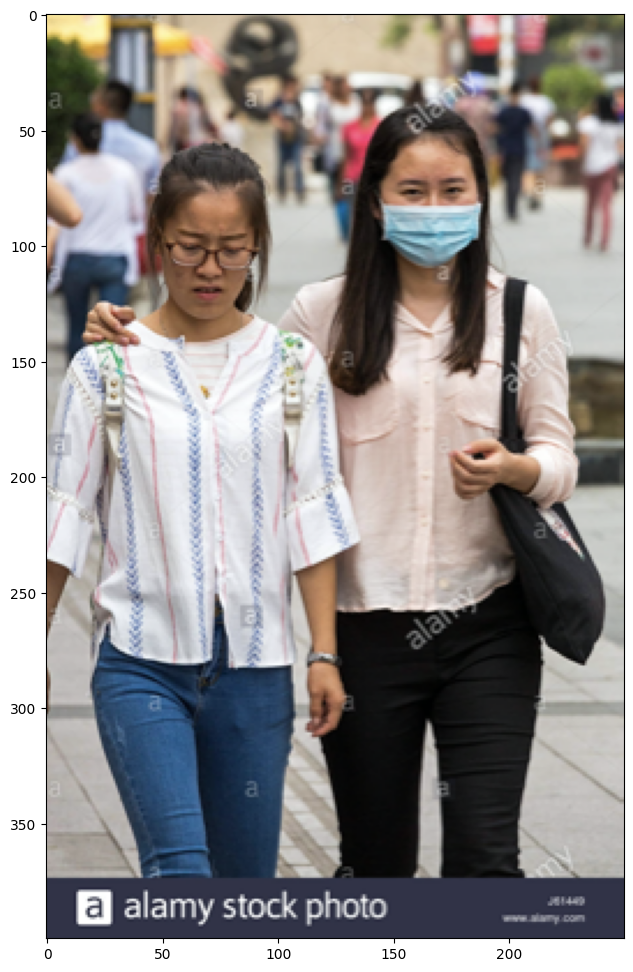

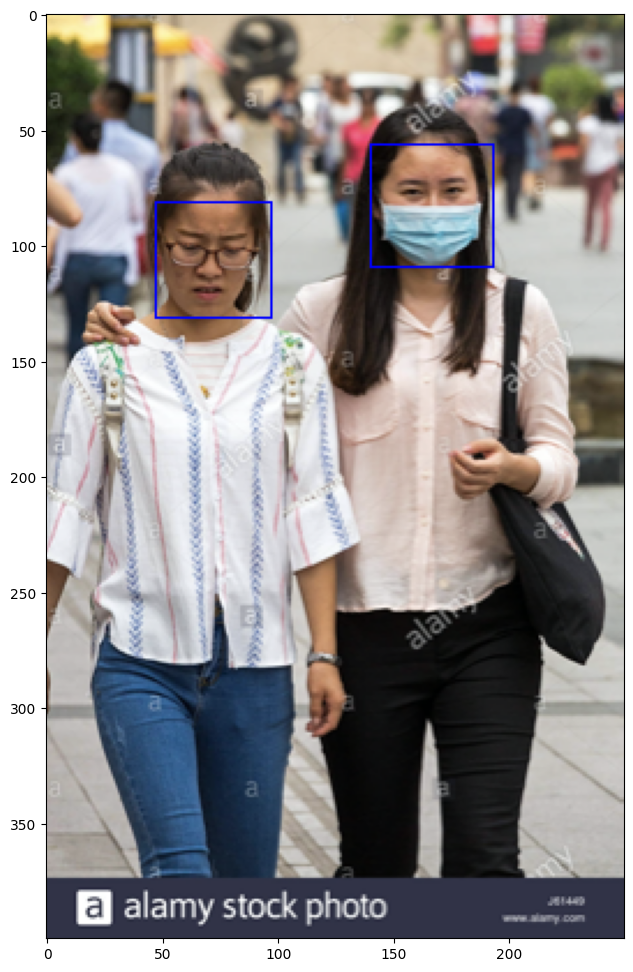

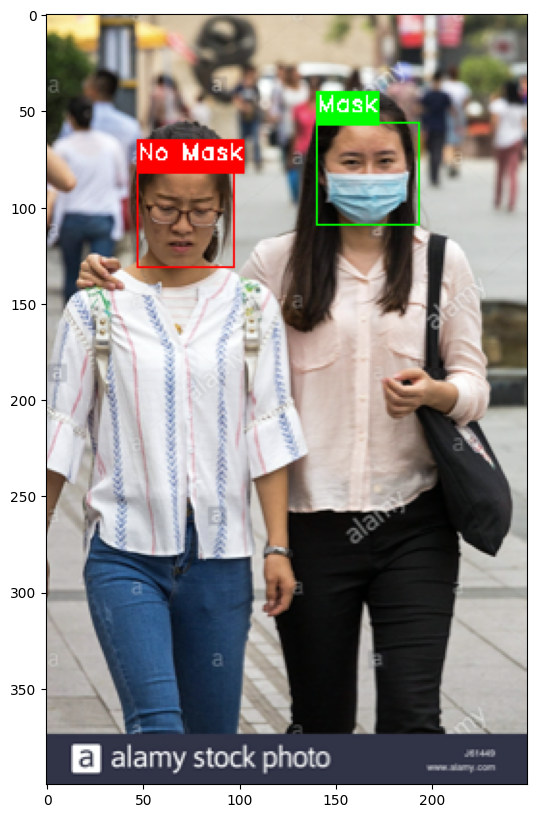

In [ ]:
import os

def inference(image_path):
    # Read a sample image
    img = cv2.imread(image_path)

    # Keep a copy of coloured image
    orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image
    plt.figure(figsize=(12, 12))
    plt.imshow(orig_img)

    # Convert image to grayscale
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)


    # loading haarcascade_frontalface_default.xml
    face_detection_model = cv2.CascadeClassifier("/content/haarcascade_frontalface_alt.xml")

    # detect faces in the given image
    return_faces = face_detection_model.detectMultiScale(
        img, scaleFactor=1.08, minNeighbors=4
    )  # returns a list of (x,y,w,h) tuples

    # plotting the returned values
    for (x, y, w, h) in return_faces:
        cv2.rectangle(orig_img, (x, y), (x + w, y + h), (0, 0, 255), 1)

    plt.figure(figsize=(12, 12))
    plt.imshow(orig_img)

    # label for mask detection
    mask_det_label = {0: "Mask", 1: "No Mask"}
    mask_det_label_colour = {0: (0, 255, 0), 1: (255, 0, 0)}
    pad_y = 1  # padding for result text

    finetuned_model=load_model('finetuned-vgg19.h5')

    main_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

    # For detected faces in the image
    for i in range(len(return_faces)):
        (x, y, w, h) = return_faces[i]
        cropped_face = main_img[y : y + h, x : x + w]
        cropped_face = cv2.resize(cropped_face, (128, 128))
        cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
        mask_result = finetuned_model.predict(cropped_face)  # make model prediction
        print_label = mask_det_label[mask_result.argmax()] # get mask/no mask based on prediction
        label_colour = mask_det_label_colour[mask_result.argmax()] # green for mask, red for no mask

        # Print result
        (t_w, t_h), _ = cv2.getTextSize(
            print_label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1
        )  # getting the text size

        cv2.rectangle(
            main_img,
            (x, y + pad_y),
            (x + t_w, y - t_h - pad_y - 6),
            label_colour,
            -1,
        )  # draw rectangle

        cv2.putText(
            main_img,
            print_label,
            (x, y - 6),
            cv2.FONT_HERSHEY_DUPLEX,
            0.4,
            (255, 255, 255), # white
            1,
        )  # print text

        cv2.rectangle(
            main_img,
            (x, y),
            (x + w, y + h),
            label_colour,
            1,
        )  # draw bounding box on face

    plt.figure(figsize=(10, 10))
    plt.imshow(main_img)  # display image

# Path to the folder containing the images
images_folder_path = "/content/images/maksssksksss352.png"  # Replace with the actual path to your images folder

# # Loop through each image in the folder
# for img_name in os.listdir(images_folder_path):
#     img_path = os.path.join(images_folder_path, img_name)

#     # Call the inference function for each image
inference(images_folder_path)


### REFERENCE I USED FOR THIS CODE
[ashineekesanam/face-mask-detection-in-crowded-places-using-keras](https://www.kaggle.com/code/ashineekesanam/face-mask-detection-in-crowded-places-using-keras)